In [71]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [112]:
non_categorical_features = ['price']
# non_categorical_features = ['price','price_t_plus_1']
# non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4',
#                             'sgd_exchange_rate_t_minus_6','price_t_plus_1']

In [113]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)
df = df[non_categorical_features]

In [114]:
df['price_t_minus_1'] = df.price.shift()
df.fillna(method='bfill', inplace=True)
df.price_t_minus_1 = df.price_t_minus_1.astype(np.int32)
df['price_2_day_ma'] = np.rint((df.price + df.price_t_minus_1) / 2).astype(np.int32)
del df['price_t_minus_1']

df['price_t_plus_2'] = df.price.shift(-2)
df.fillna(method='ffill', inplace=True)
df.price_t_plus_2 = df.price_t_plus_2.astype(np.int32)
del df['price']

In [115]:
df

price_2_day_ma  price_t_plus_2
2017-01-01            1417            1409
2017-01-02            1426            1542
2017-01-03            1422            1582
2017-01-04            1476            1529
2017-01-05            1562            1589
...                    ...             ...
2019-12-27            1606            1579
2019-12-28            1598            1602
2019-12-29            1584            1609
2019-12-30            1590            1609
2019-12-31            1606            1609

[1095 rows x 2 columns]

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 2 columns):
price_2_day_ma    1095 non-null int32
price_t_plus_2    1095 non-null int32
dtypes: int32(2)
memory usage: 17.1 KB


In [117]:
y = df.price_t_plus_2
del df['price_t_plus_2']
# y = df.price_t_plus_1
# del df['price_t_plus_1']

In [118]:
tscv = TimeSeriesSplit(n_splits=8, max_train_size=128)
tscv

TimeSeriesSplit(max_train_size=128, n_splits=8)

In [119]:
list_X_y = list()

for train_index, test_index in tscv.split(df):
#     X_train, X_test = df.iloc[train_index], df.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    list_X_y.append(dict(X=df.iloc[train_index], y=y.iloc[train_index]))
#     print(X_train[:1])
#     break

In [120]:
# X_test = X_test[:X_train.shape[0]]
# y_test = y_test[:X_train.shape[0]]

In [121]:
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.7, random_state=random_state, shuffle=False)

In [122]:
# X_train.shape

In [123]:
# X_test.shape

In [124]:
# X_train[-3:]

In [125]:
# X_test[:3]

In [126]:
y_hat_best = None
max_r2 = None

for X_y in list_X_y:
    est = linear_model.LinearRegression(normalize=False)
    est.fit(X_y['X'], X_y['y'])
    y_hat = np.rint(est.predict(df))
    this_r2 = r2_score(y, y_hat)
    print(round(this_r2,4))
    
    if not max_r2 or this_r2 > max_r2:
        max_r2 = this_r2
        y_hat_best = y_hat

0.8269
0.8372
0.8296
0.8565
0.8201
0.864
0.8703
0.8628


In [127]:
# est.score(X_test, y_test)

In [128]:
%run get_relative_accuracy.ipynb

In [129]:
# y_hat = np.rint(est.predict(X_test))

In [130]:
get_relative_accuracy(y.values, y_hat_best)

0.6639269406392694

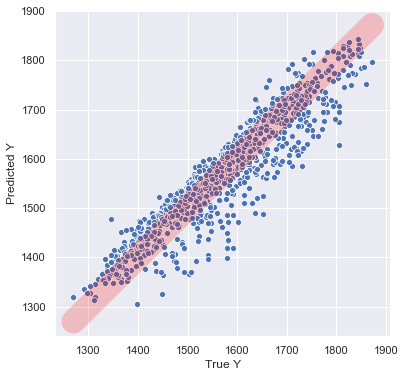

In [131]:
plot_score(y, y_hat_best)

In [132]:
# 73% using today's price
# 66% using 2day ma